In [1]:
import time
start = time.time()

In [2]:
import sys
transformer_path = 'D:\FAST\FYP\FYP23-Deep-Document-Clustering\Transformer' # ==== Path for transformer folder
sys.path.insert(0, transformer_path)

In [3]:
import os
data_path = "D:/FAST/FYP/FYP23-Deep-Document-Clustering/data/" # ===== Path for data

In [4]:
import numpy as np
import pandas as pd
import nltk
import warnings
from collections import defaultdict
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from nltk.corpus import wordnet as wn, stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.metrics import f1_score 
from concurrent.futures import ThreadPoolExecutor
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import torch
import random

from utils.PositionalEncoding import PositionalEncoding
from utils.Encoder import Encoder

os.environ['OMP_NUM_THREADS'] = '1'
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.cluster._kmeans")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.feature_extraction.text")


c:\Users\Ali Ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
if torch.cuda.is_available():
    print(f"Available GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

Available GPU: NVIDIA GeForce RTX 4090


In [6]:
torch.cuda.memory_allocated()

0

In [7]:
def reset_random_seeds(seed):
   os.environ['PYTHONHASHSEED']=str(seed)
   torch.manual_seed(seed)
   np.random.seed(seed)
   random.seed(seed)

def Purity_Score(label_seq, pred_labels):
    # Calculate the confusion matrix to compare true labels and cluster assignments
    confusion = confusion_matrix(label_seq, pred_labels)
    # Calculate the purity
    purity = np.sum(np.max(confusion, axis=0)) / np.sum(confusion)
    return purity

def Evaluate(X, true_labels, predicted_labels):
    purity = Purity_Score(true_labels, predicted_labels)
    silhouette = silhouette_score(X, predicted_labels, metric='euclidean')
    ari = ari_score(true_labels, predicted_labels)
    nmi = nmi_score(true_labels, predicted_labels)
    
    print(f"Purity: {purity}")
    print(f"Silhouette Score: {silhouette}")
    print(f"ARI Score: {ari}")
    print(f"NMI Score: {nmi}")

def SaveFeatures(X, file_name):
    pickle_path = open(file_name, 'wb')
    pickle.dump(X, pickle_path)
    pickle_path.close()

def ReadFeatures(file_name):
    pickle_read = open(file_name, 'rb')
    x = pickle.load(pickle_read)
    pickle_read.close()
    return x

In [8]:
os.chdir(data_path)

In [9]:
x = np.loadtxt('bbc.txt', dtype=float)
y = np.loadtxt('bbc_label.txt', dtype=int)

In [10]:
x = torch.tensor(x, dtype=torch.float32)

In [11]:
x.device

device(type='cpu')

In [12]:
x.size()

torch.Size([2225, 9635])

In [13]:
d_model = 9635
num_heads = 1
drop_prob = 0.1
batch_size = 25
max_sequence_length = 2225
ffn_hidden = 2048
num_layers = 5

In [14]:
pe = PositionalEncoding(d_model=d_model, max_sequence_length=max_sequence_length)
positional_encoding = pe.forward()

In [15]:
positional_encoding = positional_encoding[:,0:-1]
positional_encoding.size()

torch.Size([2225, 9635])

In [16]:
x = x + positional_encoding

In [17]:
x = x.reshape(shape=(batch_size, x.size()[0] // batch_size, x.size()[1]))

In [18]:
x.size()

torch.Size([25, 89, 9635])

In [19]:
x = x.cuda()

In [20]:
x.device

device(type='cuda', index=0)

In [21]:
reset_random_seeds(42)

In [22]:
encoder = Encoder(d_model=d_model, ffn_hidden=ffn_hidden, num_heads=num_heads, drop_prob=drop_prob, num_layers=num_layers).cuda()

In [23]:
torch.cuda.memory_allocated()

8311347712

In [24]:
for i in encoder.parameters():
    print(i.is_cuda)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [25]:
out = encoder(x)

x.size(): torch.Size([25, 89, 9635])
tensor([[[ 2.6300e-02,  1.0792e+00,  1.0320e-01,  ...,  0.0000e+00,
           1.0000e+00,  0.0000e+00],
         [ 8.4147e-01,  5.4030e-01,  8.9384e-01,  ...,  1.0029e-04,
           1.0000e+00,  1.0010e-04],
         [ 9.0930e-01, -3.4795e-01,  9.1088e-01,  ...,  2.0057e-04,
           1.0000e+00,  2.0019e-04],
         ...,
         [-9.2346e-01, -3.8370e-01, -8.4828e-01,  ...,  8.6246e-03,
           9.9996e-01,  8.6081e-03],
         [-8.2182e-01,  6.0655e-01, -9.0474e-01,  ...,  8.7249e-03,
           9.9996e-01,  8.7082e-03],
         [ 3.5398e-02,  9.9937e-01, -7.8789e-02,  ...,  8.8252e-03,
           9.9996e-01,  8.8083e-03]],

        [[ 8.6007e-01,  5.4248e-01,  8.1386e-01,  ...,  8.9254e-03,
           9.9996e-01,  8.9084e-03],
         [ 8.9400e-01, -4.1507e-01,  9.5746e-01,  ...,  9.0257e-03,
           9.9996e-01,  9.0085e-03],
         [ 1.0599e-01, -9.9437e-01,  2.7636e-01,  ...,  9.1260e-03,
           9.9996e-01,  9.1086e-03],
  

In [26]:
del encoder

In [27]:
def KMeans_Labels(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    num_clusters = n
    
    # find centoids which give maximum purity
    purity_collection = {}
    for i in range(rstate_limit):
        clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=i, init='k-means++').fit(X).labels_
        purity_collection[i] = Purity_Score(true_labels, clusters)
    
    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the TF-IDF data
    kmeans.fit(X)
    # Get the cluster assignments for each document
    cluster_assignments = kmeans.labels_
    
    return cluster_assignments

def plot_graph(x, y):
    plt.scatter(x, y, marker = "o")
    plt.title("Purity x Random State")
    plt.ylabel("Purity")
    plt.xlabel("Random State")
    plt.show()

def calculate_purity(random_state, X, true_labels):
    clusters = KMeans(n_init='auto', n_clusters=num_clusters, random_state=random_state, init='k-means++').fit(X).labels_
    purity = Purity_Score(true_labels, clusters)
    return random_state, purity

def KMeans_Labels_Parallel(X, n, rstate_limit, true_labels):
    # Specify the number of clusters (you can choose an appropriate value)
    global num_clusters
    num_clusters = n
    
    # Use ThreadPoolExecutor to parallelize purity calculations
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(calculate_purity, i, X, true_labels): i for i in range(rstate_limit)}

    purity_collection = {future.result()[0]: future.result()[1] for future in futures}

    max_rand_state = max(purity_collection, key=purity_collection.get)
    print(f"Maximum purity of {purity_collection[max_rand_state]} found on random state {max_rand_state}")

    plot_graph(purity_collection.keys(), purity_collection.values())
    
    # Create a KMeans model
    kmeans = KMeans(n_init='auto', n_clusters=num_clusters, random_state=max_rand_state, init='k-means++')
    # Fit the KMeans model to the data
    kmeans.fit(X)
    # Get the cluster assignments for each data point
    cluster_assignments = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_
    
    return cluster_assignments, cluster_centers


In [28]:
reshaped_out = out.reshape(out.size()[0] * out.size()[1], out.size()[2])

Maximum purity of 0.9568539325842697 found on random state 83


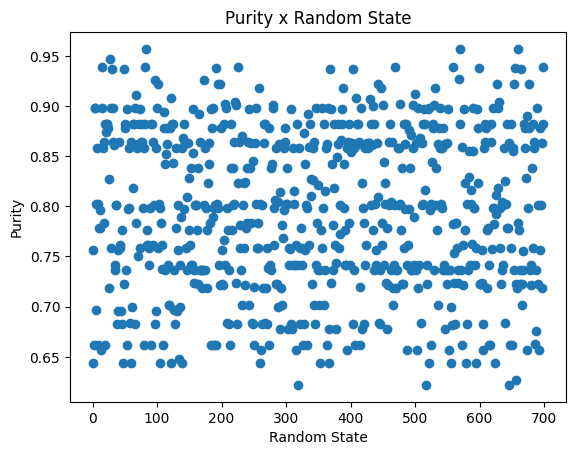

In [29]:
enhanced_x = reshaped_out.cpu().detach().numpy()
true_labels = y
pred_lables, centoids = KMeans_Labels_Parallel(enhanced_x, 5, 700, true_labels)

In [30]:
Evaluate(enhanced_x, true_labels, pred_lables)

Purity: 0.9568539325842697
Silhouette Score: 0.10930003970861435
ARI Score: 0.8964100017894705
NMI Score: 0.8990337694021349


In [31]:
def visualize_clusters(X, cluster_assignments, cluster_centers, num_dimensions=2):
    # Apply PCA to reduce the dimensions for visualization
    pca = PCA(n_components=num_dimensions)
    X_pca = pca.fit_transform(X)

    # Combine data and cluster assignments into a DataFrame
    data_with_clusters = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, num_dimensions+1)])
    data_with_clusters['Cluster'] = cluster_assignments

    # Scatter plot with different colors for each cluster
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=data_with_clusters, palette='viridis', s=80, alpha=0.8)
    
    # Plot cluster centers if available
    centers = pca.transform(cluster_centers)
    plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='X', s=200, label='Cluster Centers')
    
    plt.title('Cluster Visualization (PCA)')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()


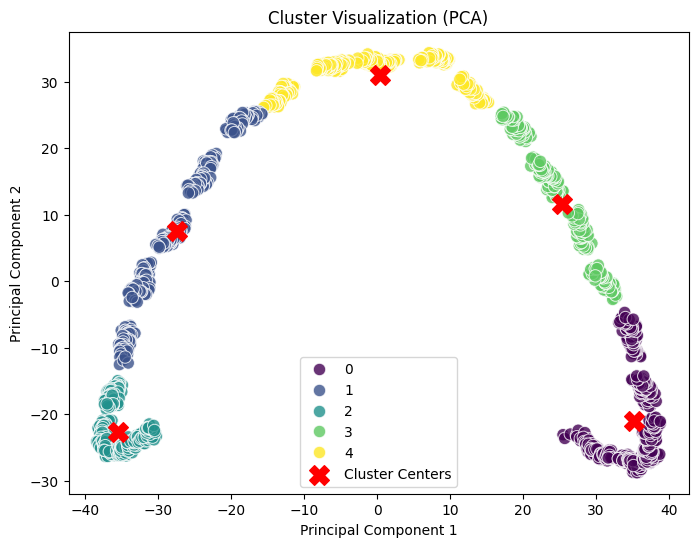

In [32]:
visualize_clusters(enhanced_x, pred_lables, cluster_centers=centoids, num_dimensions=2)

In [33]:
i=0
while i<len(true_labels):
    print(f"From {i} - {i+300}")
    print(true_labels[i:i+300])
    print(pred_lables[i:i+300])
    i+=300

From 0 - 300
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0

In [34]:
end = time.time()
time_taken = end - start

In [35]:
print(f"Time taken: {time_taken:.2f}s")

Time taken: 141.48s
